# Lezione 20

In [ ]:
from textwrap import indent

from liblet import ANTLR, Stack, Tree, AnnotatedTreeWalker

In [ ]:
! rm -f symboltable.py

## Un linguaggio con scoping di blocco

Aggiungiamo a `SimpleLang` la nozione di *blocco* e assumiamo che lo *scoping* sia per blocco, come ad esempio in Java, o C.

In [ ]:
SimpleBlockLang = ANTLR(r"""grammar SimpleBlockLang;

program: stat+ EOF;

block: '{' stat* '}' ;

expr: '!' expr            #notExpr
    | expr '*' expr       #prodExpr
    | expr ('+'|'-') expr #addSubExpr
    | expr '==' expr      #equalityExpr
    | ID                  #varRefExpr
    | INT                 #intExpr
    | '(' expr ')'        #subExpr
    ;

stat: block                                 #blockStat
    | 'var' ID ('=' expr)? ';'              #varDeclStat
    | 'if' expr 'then' stat ('else' stat)?  #ifElseStat
    | 'repeat' expr 'times' stat            #repeatStat
    | ID '=' expr ';'                       #assignementStat
    ;

ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

In [ ]:
SimpleBlockLang.save('SimpleBlockLang.g') # salvato per una prossima lezione

In [ ]:
source = r"""
var n = 0;
var somma = 0;
if INPUT0 == 3 then 
  OUTPUT = 1;
else {
  repeat INPUT0 times {
    {var n = 3;}
    n = n + 1;
    somma = somma + n;
  }
  OUTPUT = somma;
}
"""

### Costruzione dell'AST

Partiamo dalla costruzione ottenuta con `simple2ast`

In [ ]:
# recuperato dalla scorsa lezione

simpleBlock2ast = AnnotatedTreeWalker.load('simple2ast.atw') 

Va aggiunto il caso della regola `blockStat`

In [ ]:
@simpleBlock2ast.register
def blockStat(visit, ptree):
  _, *stats, _ = ptree.children[0].children
  return Tree({'type': 'blockStat'}, [visit(stat) for stat in stats])

e vanno modificati quelli delle regole `ifElseStat` (che ora si può gestire generando due tipo di nodo diverso nell'AST ed evitando l'orrore dell'attributo `elsePos`) e `repeatStat`.

In [ ]:
@simpleBlock2ast.register
def ifElseStat(visit, ptree):
  if len(ptree.children) == 6:
    _, cond, _, true, _, false = ptree.children
    return Tree({'type': 'ifElseStat'}, [visit(cond), visit(true), visit(false)])
  else:
    _, cond, _, true = ptree.children
    return Tree({'type': 'ifStat'}, [visit(cond), visit(true)])

@simpleBlock2ast.register
def repeatStat(visit, ptree):
  _, count, _, stat = ptree.children
  return Tree({'type': 'repeatStat'}, [visit(count), visit(stat)])

In [ ]:
simpleBlock2ast.save('simpleBlock2ast.atw')

Sul sorgente di cui sopra…

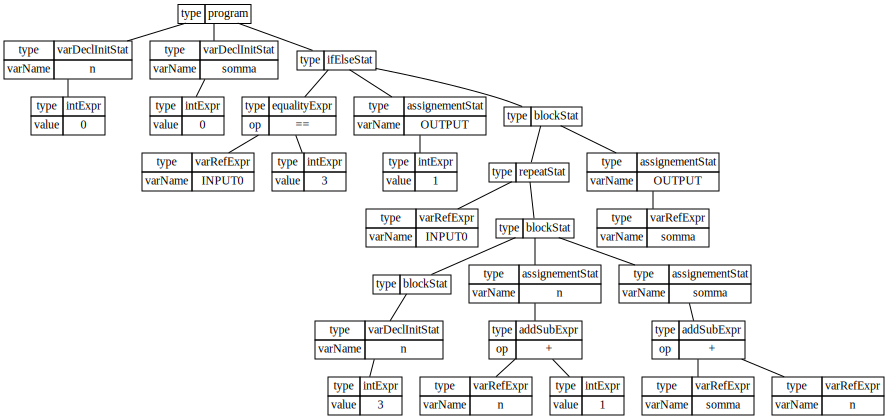

In [ ]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
ast

### Verso Python

Volendo transpilare questo AST in una stringa Python resta da risolvere la questione che Python non supporta lo scoping di blocco; per questa ragione mapperemo ogni variabile di blocco del linguaggio di partenza in una nuova variabile globale Python.

Abbiamo bisogno di una mappa tra variabili di blocco e globali. A tale scopo useremo una *symbol table*

## Symbol table 

Consideriamo un paio di implementaioni seguendo il capitolo 3 di ICD.

Iniziamo dal caso "immutabile" (che il testo chiama "persistente"). L'implementazione è data da una **funzione** in grado di reperire l'informazione associata al dato simbolo.

In [ ]:
def empty():
  def _lookup(needle):
    raise ValueError(f'Symbol {needle} not found')
  return _lookup

def bind(symbol_table, symbol, info):
  def _lookup(needle):
    if needle == symbol: return info
    return lookup(symbol_table, needle)
  return _lookup

def lookup(symbol_table, needle):
  return symbol_table(needle)

# enter e exit sono risolte mantenendo riferimenti alle symbol-table 

In [ ]:
ST = empty()
ST = bind(ST, 'x', 'global')
ST = bind(ST, 'y', 'global')

# enter
OLD = ST
ST = bind(ST, 'x', 'block')
print('x', lookup(ST, 'x'))
print('y', lookup(ST, 'y'))

# exit
ST = OLD
print('x', lookup(ST, 'x'))

x block
y global
x global


Passiamo ora all'implementazione che il testo chiama "imperativa", basata su una **pila**.

In [ ]:
def empty():
  return Stack()

def bind(symbol_table, symbol, info):
  symbol_table.push((symbol, info))

def lookup(symbol_table, needle):
  for haystack, info in reversed(symbol_table):
    if haystack == needle: return info
  else:
    raise ValueError(f'Symbol {needle} not found')

def enter(symbol_table):
  symbol_table.push((None, None))

def exit(symbol_table):
  while symbol_table and symbol_table.peek() != (None, None):
    symbol_table.pop()

In [ ]:
ST = empty()
bind(ST, 'x', 'global')
bind(ST, 'y', 'global')

enter(ST)
bind(ST, 'x', 'block')
print('x', lookup(ST, 'x'))
print('y', lookup(ST, 'y'))

exit(ST)
print('x', lookup(ST, 'x'))

x block
y global
x global


Per finire, consideriamo l'implementazione che useremo qui e nel seguito del corso, basata su un **albero di dizionari**.

In [ ]:
class SymbolTable:

  def __init__(self, parent = None):
    self.parent = parent
    self.symbol2info = {}

  def bind(self, symbol, info):
    self.symbol2info[symbol] = info

  def lookup(self, symbol):
    if symbol in self.symbol2info: return self.symbol2info[symbol]
    if self.parent: return self.parent.lookup(symbol)
    raise ValueError(f'Symbol {symbol} not found')

  def enter(self):
    return SymbolTable(self)

  def exit(self):
    if self.parent is None: raise ValueError('No containing SymbolTable')
    return self.parent

  def __repr__(self):
    def _id(x): return '…' + str(id(x))[-3:]
    ids = [_id(self)] + ([_id(self.parent)] if self.parent else [])
    return f'SymbolTable({", ".join(ids)})'

In [ ]:
%history -l 1 -f symboltable.py # salvo il codice precedente

In [ ]:
ST = SymbolTable()
ST.bind('x', 'global')
ST.bind('y', 'global')

ST = ST.enter()
ST.bind('x', 'block')
print('x', ST.lookup('x'))
print('y', ST.lookup('y'))

ST = ST.exit()
print('x', ST.lookup('x'))

x block
y global
x global


## Decoriamo l'AST con la Symbol Table

Nella *symbol table* memorizziamo per ogni variabile il suo nome "protetto" ossia prefissato da un identificatore unico ottenuto "numerando" gli identificatori man mano che vengono trovati nell'AST.

In [ ]:
def addScopeST(ast, st):
  global NUM_VARS
  
  if ast.attr.type == 'blockStat': 
    st = st.enter()
  elif ast.attr.type in {'varDeclStat', 'varDeclInitStat'}:
    st.bind(ast.attr.varName, f'I_{NUM_VARS}')
    NUM_VARS += 1
  ast.attr._st = st
  for child in ast.children: addScopeST(child, st)

Sempre sul sorgete di cui sopra…

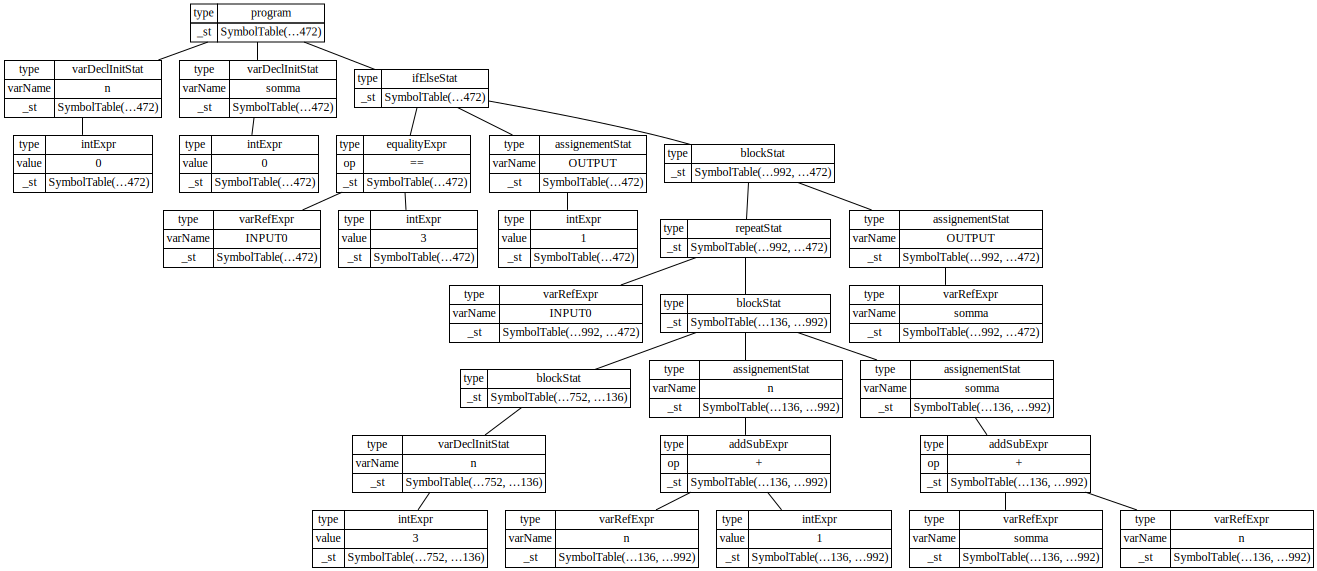

In [ ]:
ST = SymbolTable()
NUM_VARS = 0
addScopeST(ast, ST)
ast

## Transpilazione verso Python (come stringa)

Usiamo la solita tecnica… 

In [ ]:
simple2pystr = AnnotatedTreeWalker('type')

Per prima cosa occupiamoci di "tradurre" i nomi originali delle variabili nei nomi "protetti"

In [ ]:
def getPyName(atree):
  varName = atree.attr.varName
  if varName.startswith('INPUT') or varName == 'OUTPUT': return varName
  return atree.attr._st.lookup(varName)

Questo riguarda ovviamente tutti i tipi di nodo che hanno a che fare con le variabili (dichiarazione, uso e assegnamento)

In [ ]:
@simple2pystr.register
def varDeclStat(visit, atree):
  return f'{getPyName(atree)} = 0'

@simple2pystr.register
def varDeclInitStat(visit, atree):
  return f'{getPyName(atree)} = {visit(atree.children[0])}'

@simple2pystr.register
def varRefExpr(visit, atree):
  return getPyName(atree)

@simple2pystr.register
def assignementStat(visit, atree):
  return f'{getPyName(atree)} = {visit(atree.children[0])}'

Per il resto dei tipi dei nodi, la traduzione è banale…

In [ ]:
def addtab(src): return indent(src, '\t')

@simple2pystr.register
def intExpr(visit, atree):
  return str(atree.attr.value)

@simple2pystr.register
def addSubExpr(visit, atree):
  left, right = atree.children
  return f'{visit(left)} {atree.attr.op} {visit(right)}'

@simple2pystr.register
def equalityExpr(visit, atree):
  left, right = atree.children
  return f'{visit(left)} {atree.attr.op} {visit(right)}'

@simple2pystr.register
def ifStat(visit, atree):
  cond, true = atree.children
  return f'if {visit(cond)}:\n{addtab(visit(true))}' 

@simple2pystr.register
def ifElseStat(visit, atree):
  cond, true, false = atree.children
  return f'if {visit(cond)}:\n{addtab(visit(true))}\nelse:\n{addtab(visit(false))}' 

@simple2pystr.register
def repeatStat(visit, atree):
  count, stat = atree.children
  return f'for rv in range({visit(count)}): \n{addtab(visit(stat))}' 

@simple2pystr.register
def program(visit, atree):
  return '\n'.join(visit(child) for child in atree.children)

@simple2pystr.register
def blockStat(visit, atree):
  return '\n'.join(visit(child) for child in atree.children)

Facciamo un esempio sul codice sorgente di cui sopra

In [ ]:
code = simple2pystr(ast)
print(source) 
print("=" * 10)
print(code)


var n = 0;
var somma = 0;
if INPUT0 == 3 then 
  OUTPUT = 1;
else {
  repeat INPUT0 times {
    {var n = 3;}
    n = n + 1;
    somma = somma + n;
  }
  OUTPUT = somma;
}

I_0 = 0
I_1 = 0
if INPUT0 == 3:
	OUTPUT = 1
else:
	for rv in range(INPUT0): 
		I_2 = 3
		I_0 = I_0 + 1
		I_1 = I_1 + I_0
	OUTPUT = I_1


Eseguiamolo con `exec` (con 10 e 3 proviamo i due rami dell'`if` esterno)

In [ ]:
INPUT0 = 10
exec(code)
print(OUTPUT)

55


In [ ]:
INPUT0 = 3
exec(code)
print(OUTPUT)

1


### Repeat annidati

Funzionano, anche usando la stessa variabile Pytnon…

In [ ]:
source = r"""
var n = 0;
repeat 3 times
  repeat 2 times
    n = n + 1;
OUTPUT = n;
"""

In [ ]:
ast = simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))
ST = SymbolTable()
NUM_VARS = 0
addScopeST(ast, ST)
code = simple2pystr(ast)
print(code)

I_0 = 0
for rv in range(3): 
	for rv in range(2): 
		I_0 = I_0 + 1
OUTPUT = I_0


In [ ]:
exec(code)
OUTPUT

6